Image(filename='tec_logo.jpg', width=100)
###                            OPTIMAL ENERGY SCHEDULING


### In this problem we are asked to address the optimal scheduling of both conventional fossil-fuel and solar photovoltaic power such that power demand of a typical city is met, at minimum power production cost, as shown in the next figure:


<img src="ES_fig1.png" width=800> 

### As shown in the figure above, we will assume that solar photovoltaic power can diverted either directly to the comercial power grid or to a battery storage facility. 

### Both 24-h energy demand and available solar power [kWh] forecasts are shown in the next figure (by the time being we will assume limitless conventional power supply):


LoadError: syntax: extra token "IPython" after end of expression

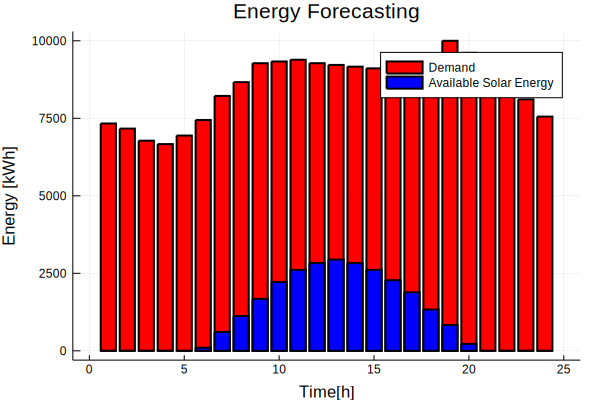

In [2]:
using Plots
Demand  = ones(24)
Epvprod = ones(24)
Demand  = [7333; 7168; 6778; 6668; 6944; 7444; 8222; 8666; 9277; 9333; 9389; 9277; 9222; 9166; 9111;  
           9166; 9277; 9500; 10000; 9611; 9277; 8333; 8111; 7555]
Epvprod = [0; 0; 0; 0; 0; 100; 611; 1122; 1677; 2222; 2611; 2833; 2944; 2830; 2610; 2277; 1888; 1333;
           833; 222; 0; 0; 0; 0];

plot(Demand, color=:red,line = :bar, title="Energy Forecasting",label="Demand",lw=2,xlabel="Time[h]",ylabel="Energy [kWh]")
plot!(Epvprod, color=:blue,line = :bar, label="Available Solar Energy",lw=2)

In [3]:
dt     = 1               # Interval size for time discretization [h] 
time   = 24              # 24 hrs in a day
eta    = 1
np     = convert(Int64, time/dt)
ni     = 1:np
Bmax   = 20000           # Maximum amount of stored energy [kWh]
Bmin   = 0.3*Bmax        # Minimum amount of stored energy [kWh]
Bstart = 0.7*Bmax        # Amount of initial stored energy
Epvch  = 2000            # Maximum battery energy charge [kWh] 
Ebdch  = 4000            # Maximn battery energy discharge [kWh]
Pc     = ones(np)        # Net Conventional power plant profit [$/kWh] 
Ppv    = ones(np)        # Net Photovoltaic solar plant profit [$/kWh]
Pb     = ones(np)        # Net Battery profit [$/kWh]
H      = 0.1150*ones(np) # Gross Energy profit [$/kWh]
Cpv    = 0.01*ones(np)   # Cost of solar photovoltaic energy [$/kWh]
Cb     = 0.011*ones(np)  # Cost of battery stored energy
for j  = 1:np
    Pc[j]  = H[j]-max(0.08,0.1*Demand[j]/maximum(Demand))
    Ppv[j] = Cpv[j]
    Pb[j]  = Cb[j]
end

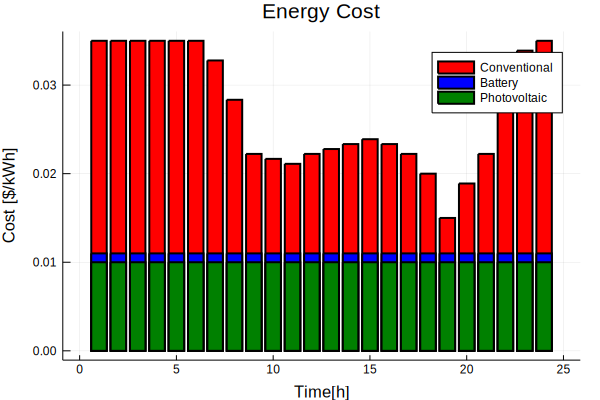

In [4]:
plot(Pc, color=:red,title="Energy Cost",line = :bar, label="Conventional",lw=2,xlabel="Time[h]",ylabel="Cost [\$/kWh]")
plot!(Pb, color=:blue,line = :bar, label="Battery",lw=2)
plot!(Ppv, color=:green,line = :bar, label="Photovoltaic",lw=2)

In [5]:
using JuMP, Clp,  Printf

In [6]:
energy_scheduling = Model(solver=ClpSolver());

In [7]:
@variable(energy_scheduling, Ec[i in ni]   >= 0, start = sum(Demand)/np)
@variable(energy_scheduling, Epv[i in ni]  >= 0, start = sum(Demand)/np)
@variable(energy_scheduling, Epvb[i in ni] >= 0, start = sum(Demand)/np)
@variable(energy_scheduling, Eb[i in ni]   >= 0, start = sum(Demand)/np)
@variable(energy_scheduling, B[i in ni]    >= 0, start = 0.5*Bmax);

#### The objective function: Maximize Power Manufacturer Profits:

$$ {\rm Min}\,\,(\Omega) = \sum_{i=1} (P^C_i E^C_i + P^{PV}_i E_i^{PV} + P_i^{B} E_i^B)$$

In [8]:
@objective(energy_scheduling, Min, sum(Pc[i]*Ec[i]+Ppv[i]*Epv[i]+Pb[i]*Eb[i] for i in ni));

#### Energy demand constraint:

$$ E_i^C + E_i^{PV} + E_i^{B} \leq D_i $$

In [9]:
@constraint(energy_scheduling, cont_demand[i in ni], Ec[i] + Epv[i] + Eb[i] >= Demand[i]);

#### The sum of solar photovoltaic energy diverted to the grid and battery should be less or equal to the available solar photovoltaic energy:  

$$ E_i^{PV,G} + E_i^{PV,B} \leq E^{PV,prod}_i $$

In [10]:
@constraint(energy_scheduling, cont_Epvt[i in ni], Epv[i] + Epvb[i] <= Epvprod[i]);

#### Amount  of energy stored in Battery:
$$ B_i = B_{initial} + \sum_{j=1}^{i}(E_j^{PV,B} - E_j^B) $$

In [11]:
@constraint(energy_scheduling, cont_esb[i in ni], B[i] == Bstart + sum(Epvb[j]-Eb[j] for j=1:i));

#### Upper and lower bounds on the amount of battery stored energy
$$ B_i <= B_{max}$$
$$ B_i >= B_{min}$$

In [12]:
@constraint(energy_scheduling, cont_bmax[i in ni], B[i] <= Bmax)
@constraint(energy_scheduling, cont_bmin[i in ni], B[i] >= Bmin);

#### At the end of the working period the amount of energy in the battery should be a fraction of the initial charge:
$$ B_{end} >= \eta \cdot B_{start} $$ 

In [13]:
@constraint(energy_scheduling, cont_bend, B[np] >= eta*Bstart);

#### Maxium rates at which Battery can be charged and discharged:
\begin{eqnarray*}
E_i^{PV,B} & \leq & E^{PV,B}_{charge}\\
E_i^{B} & \leq & E^{B}_{discharge}
\end{eqnarray*}


In [14]:
@constraint(energy_scheduling, cont_bcharge[i in ni], Epv[i]   <= Epvch)
@constraint(energy_scheduling, cont_bdischarge[i in ni], Eb[i] <= Ebdch);

In [15]:
status_energy_scheduling = solve(energy_scheduling)

:Optimal

In [16]:
println("Status of the problem is: ", status_energy_scheduling)
println("Objective function value = ", getobjectivevalue(energy_scheduling))

Status of the problem is: Optimal
Objective function value = 4895.513400000001


In [17]:
println("------------------------------------------------------------------")
println("Time   Conventional   PhotoVoltaic   Battery    TOTAL       Demand")
println("[h]        [kWh]          [kWh]       [kWh]     [kWh]        [kWh]")
println("------------------------------------------------------------------")
Ec1   = ones(np)
Epv1  = ones(np)
Eb1   = ones(np)
Epvb1 = ones(np)
B1    = ones(np)

for i=1:np
    Ec1[i]   = getvalue(Ec[i]);
    Epv1[i]  = getvalue(Epv[i]);
    Eb1[i]   = getvalue(Eb[i]);
    Epvb1[i] = getvalue(Epvb[i]);
    B1[i]    = getvalue(B[i]);
    sum_ener = Ec1[i]+Epv1[i]+Eb1[i]
    @printf " %i       %8.2f     %8.2f     %8.2f   %8.2f    %8.2f\n" i Ec1[i] Epv1[i] Eb1[i] sum_ener  Demand[i] 
end
println("------------------------------------------------------------------")

------------------------------------------------------------------
Time   Conventional   PhotoVoltaic   Battery    TOTAL       Demand
[h]        [kWh]          [kWh]       [kWh]     [kWh]        [kWh]
------------------------------------------------------------------
 1        7333.00         0.00         0.00    7333.00     7333.00
 2        7168.00         0.00         0.00    7168.00     7168.00
 3        6778.00         0.00         0.00    6778.00     6778.00
 4        2668.00         0.00      4000.00    6668.00     6668.00
 5        6944.00         0.00         0.00    6944.00     6944.00
 6        3344.00       100.00      4000.00    7444.00     7444.00
 7        7611.00       611.00         0.00    8222.00     8222.00
 8        7544.00      1122.00         0.00    8666.00     8666.00
 9        9277.00         0.00         0.00    9277.00     9277.00
 10        9333.00         0.00         0.00    9333.00     9333.00
 11        9389.00         0.00         0.00    9389.00     9

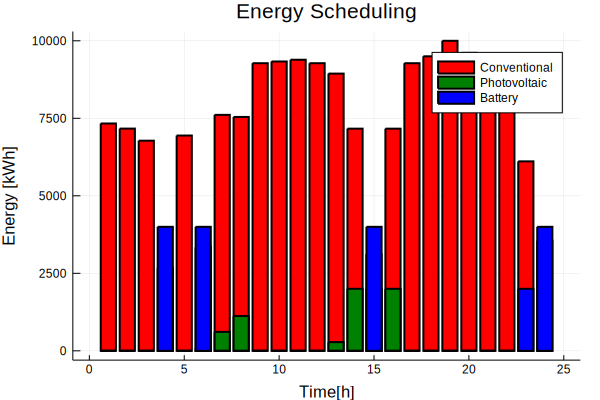

In [18]:
plot(Ec1, color=:red,title="Energy Scheduling",line = :bar, label="Conventional",lw=2,xlabel="Time[h]",
    ylabel="Energy [kWh]")
plot!(Epv1, color=:green,line = :bar, label="Photovoltaic",lw=2)
plot!(Eb1, color=:blue,line = :bar, label="Battery",lw=2)


In [19]:
println("----------------------------------------------------------")
println("Time     PV-Grid        PV-Battery  Energ-Bat   Bat-Charge")
println("[h]       [kWh]            [kWh]      [kWh]        [kWh]")
println("----------------------------------------------------------")
for i=1:np
    Ec1[i]   = getvalue(Ec[i]);
    Epv1[i]  = getvalue(Epv[i]);
    Eb1[i]   = getvalue(Eb[i]);
    Epvb1[i] = getvalue(Epvb[i]);
    B1[i]    = getvalue(B[i]);
    @printf " %i      %8.2f       %8.2f   %8.2f       %8.2f\n" i Epv1[i] Epvb1[i] Eb1[i] B1[i] 
end
println("-----------------------------------------------------------")

----------------------------------------------------------
Time     PV-Grid        PV-Battery  Energ-Bat   Bat-Charge
[h]       [kWh]            [kWh]      [kWh]        [kWh]
----------------------------------------------------------
 1          0.00           0.00       0.00       14000.00
 2          0.00           0.00       0.00       14000.00
 3          0.00           0.00       0.00       14000.00
 4          0.00           0.00    4000.00       10000.00
 5          0.00           0.00       0.00       10000.00
 6        100.00           0.00    4000.00        6000.00
 7        611.00           0.00       0.00        6000.00
 8       1122.00           0.00       0.00        6000.00
 9          0.00        1677.00       0.00        7677.00
 10          0.00        2222.00       0.00        9899.00
 11          0.00        2611.00       0.00       12510.00
 12          0.00        2833.00       0.00       15343.00
 13        280.00        2664.00       0.00       18007.00
 14     

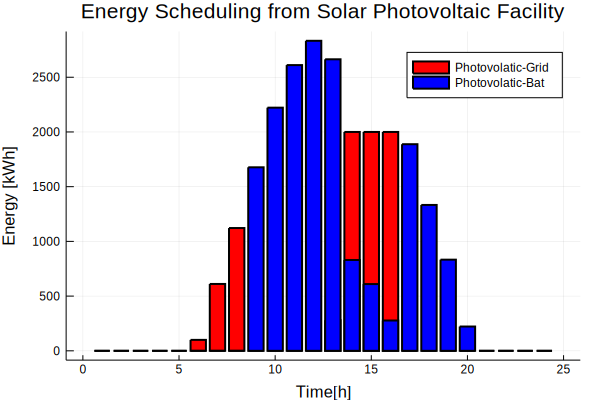

In [20]:
plot(Epv1, color=:red,title="Energy Scheduling from Solar Photovoltaic Facility",line = :bar, label="Photovolatic-Grid",lw=2,xlabel="Time[h]",
    ylabel="Energy [kWh]")
plot!(Epvb1, color=:blue,line = :bar, label="Photovolatic-Bat",lw=2)

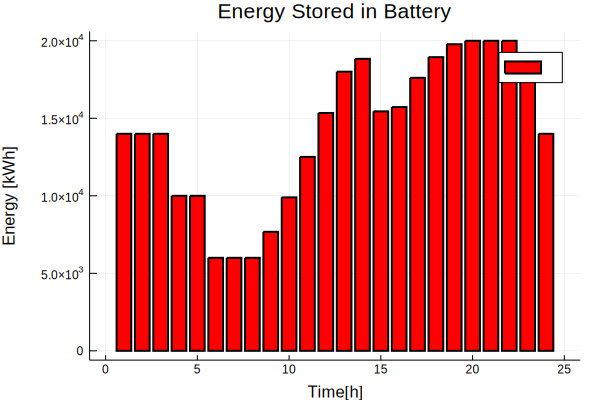

In [21]:
plot(B1, color=:red,title="Energy Stored in Battery",label= " ",line = :bar, lw=2,xlabel="Time[h]",
    ylabel="Energy [kWh]")